## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


## Load the dataset

In [2]:
data = pd.read_csv("bitcoin_ticker.csv")

In [3]:
data.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,2017-05-31 14:59:36,2017-05-31 14:59:36
1,2017-05-31,2017-06-01 00:00:00,bitflyer,btc_jpy,267098.00,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880112,2017-05-31 14:59:36,2017-05-31 14:59:36
2,2017-05-31,2017-06-01 00:00:00,korbit,btc_krw,3003500.00,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,2017-05-31 14:59:36,2017-05-31 14:59:36
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36


In [4]:
data['rpt_key'].value_counts()

btc_usd       125438
eth_krw        62719
ltc_usd        62719
btc_eur        62719
fx_btc_jpy     62719
etc_krw        62719
btc_jpy        62719
btc_krw        62719
eth_btc        62719
Name: rpt_key, dtype: int64

## Subset USD

In [5]:
df = data.loc[(data['rpt_key'] == 'btc_usd')]

In [6]:
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36
15,2017-06-01,2017-06-01 00:01:00,bitstamp,btc_usd,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698603,2017-05-31 15:00:36,2017-05-31 15:00:36
16,2017-06-01,2017-06-01 00:01:00,okcoin,btc_usd,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516,2017-05-31 15:00:36,2017-05-31 15:00:36
23,2017-06-01,2017-06-01 00:02:00,bitstamp,btc_usd,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110913,2017-05-31 15:01:36,2017-05-31 15:01:36


### Convert datetime_id to data type and filter dates greater than  2017-06-28 00:00:00

In [7]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]

In [8]:
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]

In [9]:
df.head()

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
77762,2017-06-28 00:01:00,2344.00,2491.98,-5.938250,2335.01,2343.89,2307.0,2473.19,20719.583592
77763,2017-06-28 00:01:00,2499.39,2682.25,-6.817411,2495.00,2499.33,2444.0,2780.62,2265.557866
77764,2017-06-28 00:02:00,2337.18,2491.98,-6.211928,2337.18,2340.00,2307.0,2473.19,20732.082581
77765,2017-06-28 00:02:00,2492.76,2682.25,-7.064591,2492.76,2495.00,2444.0,2780.62,2262.618866
77766,2017-06-28 00:03:00,2335.02,2491.98,-6.298606,2335.01,2335.02,2307.0,2473.19,20665.357191


### we require only the last value, so we subset that and convert it to numpy array

In [10]:
df = df[['last']]

In [11]:
dataset = df.values
dataset = dataset.astype('float32')

In [12]:
dataset

array([[2344.  ],
       [2499.39],
       [2337.18],
       ...,
       [2394.03],
       [2320.47],
       [2394.03]], dtype=float32)

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [14]:
dataset

array([[0.1997695 ],
       [0.49828053],
       [0.18666792],
       ...,
       [0.29587936],
       [0.15456724],
       [0.29587936]], dtype=float32)

In [15]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

31942 15734


In [16]:

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    

In [17]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [18]:
trainX

array([[0.1997695 , 0.49828053, 0.18666792, ..., 0.4975314 , 0.19973087,
        0.4860053 ],
       [0.49828053, 0.18666792, 0.4855442 , ..., 0.19973087, 0.4860053 ,
        0.18442059],
       [0.18666792, 0.4855442 , 0.18251848, ..., 0.4860053 , 0.18442059,
        0.48598576],
       ...,
       [0.53376245, 0.6943617 , 0.53105354, ..., 0.7082124 , 0.5205841 ,
        0.7081547 ],
       [0.6943617 , 0.53105354, 0.70823145, ..., 0.5205841 , 0.7081547 ,
        0.52665424],
       [0.53105354, 0.70823145, 0.5332055 , ..., 0.7081547 , 0.52665424,
        0.7081547 ]], dtype=float32)

In [19]:
trainY

array([0.18442059, 0.48598576, 0.19208527, ..., 0.52665424, 0.7081547 ,
       0.5206418 ], dtype=float32)

In [20]:

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Build our Model

In [21]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
 - 2s - loss: 0.1765
Epoch 2/100
 - 0s - loss: 0.0177
Epoch 3/100
 - 0s - loss: 0.0130
Epoch 4/100
 - 0s - loss: 0.0110
Epoch 5/100
 - 0s - loss: 0.0087
Epoch 6/100
 - 0s - loss: 0.0060
Epoch 7/100
 - 0s - loss: 0.0028
Epoch 8/100
 - 0s - loss: 7.4770e-04
Epoch 9/100
 - 0s - loss: 2.0813e-04
Epoch 10/100
 - 0s - loss: 1.4682e-04
Epoch 11/100
 - 0s - loss: 1.3574e-04
Epoch 12/100
 - 0s - loss: 1.2966e-04
Epoch 13/100
 - 0s - loss: 1.2561e-04
Epoch 14/100
 - 0s - loss: 1.2306e-04
Epoch 15/100
 - 0s - loss: 1.2142e-04
Epoch 16/100
 - 1s - loss: 1.2045e-04
Epoch 17/100
 - 1s - loss: 1.1989e-04
Epoch 18/100
 - 0s - loss: 1.1923e-04
Epoch 19/100
 - 0s - loss: 1.1888e-04
Epoch 20/100
 - 0s - loss: 1.1856e-04
Epoch 21/100
 - 0s - loss: 1.1822e-04
Epoch 22/100
 - 0s - loss: 1.1803e-04
Epoch 23/100
 - 0s - loss: 1.1761e-04
Epoch 24/100
 - 0s - loss: 1.1723e-04
Epoch 25/100
 - 0s - loss

In [22]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
testPredict

array([[0.5225002 ],
       [0.7208108 ],
       [0.52455974],
       ...,
       [0.1628575 ],
       [0.3048634 ],
       [0.15968272]], dtype=float32)

In [23]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
testPredict

array([[2511.9973],
       [2615.228 ],
       [2513.0696],
       ...,
       [2324.7854],
       [2398.7065],
       [2323.1328]], dtype=float32)

In [24]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 4.64 RMSE
Test Score: 5.30 RMSE


In [25]:

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [26]:

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

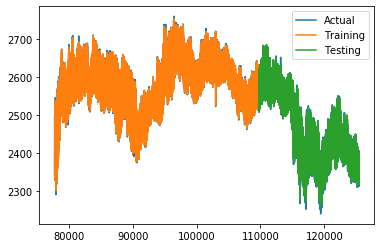

In [27]:
plt.plot(df['last'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()